---
title: Analysing reddit data - part 4: data analysis  
date: 2015-12-09  
comments: false  
tags: Python, Programming tips, Public Data, Reddit API, pandas  
keywords: python, programming, reproducible research  

---

In [last week's post]({filename}2015-11-18-reddit-api-part-1.md), we covered the basics of setting up our environment so we can extract data from reddit. Now it's time to start on the meat of this topic. This week I will show you how to use the reddit public API to retrieve JSON-encoded data from the subreddit /r/relationships, although this technique will translate to both the reddit mainpage and other subreddits. As I mentioned last week, this is aimed at people who are completely new to working with JSON data, so we will go through everything step-by-step.

In [5]:
import urllib2
import json
import time

hdr = {'User-Agent': 'osx:r/relationships.multiple.results:v1.0 (by /u/PopularCactus)'}
url = 'https://www.reddit.com/r/relationships/top/.json?sort=top&t=all&limit=100'
req = urllib2.Request(url, headers=hdr)
text_data = urllib2.urlopen(req).read()
data = json.loads(text_data)
data_all = data.values()[1]['children']

while (len(data_all) <= 1000):
    time.sleep(2)
    last = data_all[-1]['data']['name']
    url = 'https://www.reddit.com/r/relationships/top/.json?sort=top&t=all&limit=100&after=%s' % last
    req = urllib2.Request(url, headers=hdr)
    text_data = urllib2.urlopen(req).read()
    data = json.loads(text_data)
    data_all += data.values()[1]['children']

KeyboardInterrupt: 

In [6]:
len(data_all)

1000

In [7]:
article_title = []
article_flairs = []
article_date = []
article_comments = []
article_score = []

for i in range(0, len(data_all)):
    article_title.append(data_all[i]['data']['title'])
    article_flairs.append(data_all[i]['data']['link_flair_text'])
    article_date.append(data_all[i]['data']['created_utc'])
    article_comments.append(data_all[i]['data']['num_comments'])
    article_score.append(data_all[i]['data']['score'])

In [8]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd

rel_df = DataFrame({'Date': article_date,
                    'Title': article_title,
                    'Flair': article_flairs,
                    'Comments': article_comments,
                    'Score': article_score})
rel_df = rel_df[['Date', 'Title', 'Flair', 'Comments', 'Score']]

In [9]:
rel_df[:5]

,Date,Title,Flair,Comments,Score
0,1440187622,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,Updates,908,7843
1,1438962646,Update: I [30 F] am sitting in the back of my ...,◉ Locked Post ◉,631,6038
2,1435026034,UPDATE: My fiancee (24F) has no bridesmaids an...,Updates,623,5548
3,1438393090,My [42M] daughter [17F] has been bullying a gi...,◉ Locked Post ◉,970,5301
4,1440543117,[Update] My [26F] fiance's [28M] ex-wife [28F]...,Updates,767,5195


## Cleaning the data

As I pointed out in the last blog post, there are two immediately obvious issues with these data. The first is that the date is in [Unix or Epoch time](https://en.wikipedia.org/wiki/Unix_time), which represents the number of seconds that have passed since 1 January 1970. In order to convert this into a datetime format, we simply do the following:

In [10]:
rel_df['Date'] = pd.to_datetime((rel_df['Date'].values*1e9).astype(int))
rel_df[:5]

,Date,Title,Flair,Comments,Score
0,2015-08-21 20:07:02,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,Updates,908,7843
1,2015-08-07 15:50:46,Update: I [30 F] am sitting in the back of my ...,◉ Locked Post ◉,631,6038
2,2015-06-23 02:20:34,UPDATE: My fiancee (24F) has no bridesmaids an...,Updates,623,5548
3,2015-08-01 01:38:10,My [42M] daughter [17F] has been bullying a gi...,◉ Locked Post ◉,970,5301
4,2015-08-25 22:51:57,[Update] My [26F] fiance's [28M] ex-wife [28F]...,Updates,767,5195


The other issue is that when posts become locked by the subreddit moderators, the original flair is replaced with "Locked Post". This is not really the most useful label as it doesn't give us any information about the topic. 

In [11]:
import re

replace_value = rel_df['Flair'][1]
rel_df['Flair'] = rel_df['Flair'].replace(replace_value, np.nan)

rel_df['Flair'].isnull().sum()

155

You can see a substantial number (16%) of flairs were replaced with "Locked Post", which means we have a large amount of missing data in this variable. However, we can recover some information by exploiting the fact that update posts usually have the word "Update" in the title. We can use a regex to check for whether "Update" is in the title, and if so, replace the flair with "Updates". We will replace any "Locked Posts" which do not meet our regex criteria with a missing value (NaN).

In [12]:
cond1 = rel_df['Title'].str.contains(
    '^\[?[a-z!?A-Z ]*UPDATE\]?:?', flags = re.IGNORECASE)
cond2 = rel_df['Flair'].isnull()

rel_df.loc[(cond1 & cond2), 'Flair'] = rel_df.loc[(cond1 & cond2), 'Flair'].replace(np.nan, 'Updates')
rel_df[:5]

,Date,Title,Flair,Comments,Score
0,2015-08-21 20:07:02,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,Updates,908,7843
1,2015-08-07 15:50:46,Update: I [30 F] am sitting in the back of my ...,Updates,631,6038
2,2015-06-23 02:20:34,UPDATE: My fiancee (24F) has no bridesmaids an...,Updates,623,5548
3,2015-08-01 01:38:10,My [42M] daughter [17F] has been bullying a gi...,NaN,970,5301
4,2015-08-25 22:51:57,[Update] My [26F] fiance's [28M] ex-wife [28F]...,Updates,767,5195


In [13]:
rel_df['Flair'].isnull().sum()

96

You can see that we still have 10% of missing data in this variable, which is quite high. However, we have replaced some of the missing data in a robust manner. This should be bookmarked as a possible source of bias in our data for when we try and interpret our analyses.

## Extracting extra variables

As you can see from how I replaced the flairs, there is information in the post title we can use. Another convention in posts on this subreddit is that posters are asked to include their age and sex in the title. For example, you can see in the first posts above that the poster lists this information in the format [26F], indicating they are a 26 year old woman. You can probably also see a pattern in how the posters information is nested in the title as well. Looking through the data, I picked out four words that precede the posters information: "My", "I", "I'm" and "Me". We can use (a pretty complicated) regex to extract this portion of the title:

In [14]:
poster_age_sex = rel_df['Title'].str.extract(
    "((i\'m|i|my|me)\s?(\[|\()(m|f)?(\s|/)?[0-9]{1,2}(\s|/)?([m,f]|male|female)?(\]|\)))", 
        flags = re.IGNORECASE)[0]
poster_age_sex[1:5]

1    I [30 F]
2     I (25m)
3    My [42M]
4    My [26F]
Name: 0, dtype: object

Let's now clean this up a bit by getting rid of the starting word, then pulling the age and sex out into separate variables, and adding them to the DataFrame.

In [15]:
poster_age_sex = poster_age_sex.str.replace("((i\'m|i|my|me))\s?", "", flags = re.IGNORECASE)
poster_age = poster_age_sex.str.extract('([0-9]{1,2})')
poster_sex = poster_age_sex.str.extract('([m,f])', flags = re.IGNORECASE)

rel_df['PosterAge'] = pd.to_numeric(poster_age)
rel_df['PosterSex'] = poster_sex.str.upper()

rel_df[:5]

,Date,Title,Flair,Comments,Score,PosterAge,PosterSex
0,2015-08-21 20:07:02,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,Updates,908,7843,26,F
1,2015-08-07 15:50:46,Update: I [30 F] am sitting in the back of my ...,Updates,631,6038,30,F
2,2015-06-23 02:20:34,UPDATE: My fiancee (24F) has no bridesmaids an...,Updates,623,5548,25,M
3,2015-08-01 01:38:10,My [42M] daughter [17F] has been bullying a gi...,NaN,970,5301,42,M
4,2015-08-25 22:51:57,[Update] My [26F] fiance's [28M] ex-wife [28F]...,Updates,767,5195,26,F


We'll end this section by checking for missing values in our new PosterAge and PosterSex variables.

In [16]:
rel_df['PosterAge'].isnull().sum()

91

In [17]:
rel_df['PosterSex'].isnull().sum()

103

Again, these variables have fairly high amounts of missing data (9% for age 10% for sex). This is another possible source of bias to keep in mind.

Finally, we can use the date variable to obtain the day of the week that the post was created:

In [18]:
rel_df['DayOfWeek'] = rel_df['Date'].dt.dayofweek
days = {0: 'Mon', 1: 'Tues', 2: 'Weds', 3: 'Thurs', 4: 'Fri',
        5: 'Sat', 6: 'Sun'}
rel_df['DayOfWeek'] = rel_df['DayOfWeek'].apply(lambda x: days[x])

rel_df[:5]

,Date,Title,Flair,Comments,Score,PosterAge,PosterSex,DayOfWeek
0,2015-08-21 20:07:02,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,Updates,908,7843,26,F,Fri
1,2015-08-07 15:50:46,Update: I [30 F] am sitting in the back of my ...,Updates,631,6038,30,F,Fri
2,2015-06-23 02:20:34,UPDATE: My fiancee (24F) has no bridesmaids an...,Updates,623,5548,25,M,Tues
3,2015-08-01 01:38:10,My [42M] daughter [17F] has been bullying a gi...,NaN,970,5301,42,M,Sat
4,2015-08-25 22:51:57,[Update] My [26F] fiance's [28M] ex-wife [28F]...,Updates,767,5195,26,F,Tues


Checking for missing data, we (predictibly) find that no values are missing (due to the fact that every date is present):

In [19]:
rel_df['DayOfWeek'].isnull().sum()

0

## Descriptives

The starting point of any analysis is examining each of the variables, either using summary statistics (descriptives) or graphically. Let's start with the PosterAge. We can see we have 909 data points for this variable, and that posters are a median of 26 years old (IQR: 23, 29).

In [20]:
rel_df['PosterAge'].describe()

count    909.000000
mean      26.698570
std        6.323285
min       13.000000
25%       23.000000
50%       26.000000
75%       29.000000
max       57.000000
Name: PosterAge, dtype: float64

Looking at PosterSex, we can see that we have 897 data points for this variable. 542 of the posters are female (60% of non-missing values), and 355 are male (40%).

In [21]:
rel_df['PosterSex'].notnull().sum()

897

In [22]:
rel_df['PosterSex'].value_counts()

F    542
M    355
Name: PosterSex, dtype: int64

In [23]:
100 * rel_df['PosterSex'].value_counts() / rel_df['PosterSex'].notnull().sum()

F    60.423634
M    39.576366
Name: PosterSex, dtype: float64

In Flairs, we have 904 number of data points. The most common flair is "Updates" (516 posts, or 57%), and the least common is "Dating" (3, > 1%).

In [24]:
rel_df['Flair'].notnull().sum()

904

In [25]:
rel_df['Flair'].value_counts()

Updates            516
Relationships      161
Non-Romantic       158
Infidelity          38
Breakups            15
Personal issues     13
Dating               3
Name: Flair, dtype: int64

In [26]:
100 * rel_df['Flair'].value_counts() / rel_df['Flair'].notnull().sum()

Updates            57.079646
Relationships      17.809735
Non-Romantic       17.477876
Infidelity          4.203540
Breakups            1.659292
Personal issues     1.438053
Dating              0.331858
Name: Flair, dtype: float64

Examining the overall score per post, we can see that we have all 1,000 data points, and the median score per post is 1,225 (IQR: 961, 1,761).

In [27]:
rel_df['Score'].describe()

count    1000.00000
mean     1511.58000
std       822.78436
min       792.00000
25%       963.00000
50%      1224.50000
75%      1762.00000
max      7843.00000
Name: Score, dtype: float64

Similarly, the 'Comments' variable has all 1,000 data points. The median number of comments per post is 269 (IQR: 161, 421).

In [28]:
rel_df['Comments'].describe()

count    1000.000000
mean      318.964000
std       219.461632
min        15.000000
25%       161.000000
50%       269.000000
75%       421.250000
max      1693.000000
Name: Comments, dtype: float64

Finally, let's have a look at the day of the week the post was created. We already know it has all 1,000 data points, so we don't have to check that again. We can see that the highest number of the most popular posts were created during the week, with around 15% of all posts on each of the weekdays. In contrast, Sunday was the quietest day for popular posts.

In [29]:
rel_df['DayOfWeek'].value_counts()

Tues     156
Weds     155
Mon      155
Thurs    154
Fri      148
Sun      121
Sat      111
Name: DayOfWeek, dtype: int64

In [30]:
100 * rel_df['DayOfWeek'].value_counts() / rel_df['DayOfWeek'].notnull().sum()

Tues     15.6
Weds     15.5
Mon      15.5
Thurs    15.4
Fri      14.8
Sun      12.1
Sat      11.1
Name: DayOfWeek, dtype: float64

## Some basic inferential statistics

Now that we've looked at our variables, we see that there might be some interesting patterns we could analyse. 

The first thing we can look at is the behaviour of posters on the site. Let's have a look at two questions to do with this.

### Does the age distribution vary by sex?



### Poster behaviour
- Does the age distribution vary for men and women? (Chi-sq)
- Are certain topics more likely on different days of the week? (Chi-sq)

### Reader behaviour
- Are certain topics more popular (higher score and more comments)
- Are certain days of the week more popular (higher score and more comments)

## Interpretations and bias
- These are only the most popular posts, so they are not representative of the general pattern of behaviour on the site.
- Possible sources of bias include missing data on flairs (and decision to replace flairs may have increased that bias as data for the rest of the flairs is still missing), and missing sex and age information. There may be characteristics about people who don't format their titles properly (with suggested age/sex format) and the type of post (more distressed, possibly?).

In [36]:
rel_df['PosterAge'].groupby([rel_df['PosterSex']]).median()

PosterSex
F    25.5
M    27.0
Name: PosterAge, dtype: float64

In [204]:
from scipy import stats  

d = {}
for key, value in rel_df.groupby('PosterSex'):
        d['%s' % key] = value['PosterAge']

z_stat, p_val = stats.mstats.kruskalwallis(d['F'], d['M'])
print "The test statistic is %1.3f, and the significance level is %1.3f." % (z_stat, p_val)

The test statistic is 11.220, and the significance level is 0.001.


In [95]:
sex_flair = pd.crosstab(rel_df['Flair'], rel_df['PosterSex'], 
            rownames = ['Flair'], colnames=['Poster Sex']).ix[
    ['Infidelity', 'Non-Romantic', 'Relationships', 'Updates']]
sex_flair

Poster Sex,F,M
Flair,,
Infidelity,15,17
Non-Romantic,108,38
Relationships,82,68
Updates,284,175


In [102]:
sex_flair.apply(lambda c: c/c.sum() * 100, axis=0)

Poster Sex,F,M
Flair,,
Infidelity,3.067485,5.704698
Non-Romantic,22.085890,12.751678
Relationships,16.768916,22.818792
Updates,58.077710,58.724832


In [98]:
chi2, p_val, df, exp_vals = stats.chi2_contingency(sex_flair)
print "The test statistic is %1.3f, and the significance level is %1.3f." % (chi2, p_val)

The test statistic is 15.432, and the significance level is 0.001.


In [117]:
f_score_com = rel_df.groupby(['Flair'])[
    ['Score', 'Comments']].median().ix[
    ['Infidelity', 'Non-Romantic', 'Relationships', 'Updates']]
f_score_com

,Score,Comments
Flair,,
Infidelity,1145.5,320.0
Non-Romantic,1147.0,317.0
Relationships,1126.0,400.0
Updates,1285.5,200.5


In [118]:
f_score_com_pcts = f_score_com.apply(lambda c: c/c.sum() * 100, axis=0)
f_score_com_pcts

,Score,Comments
Flair,,
Infidelity,24.351616,25.858586
Non-Romantic,24.383503,25.616162
Relationships,23.937075,32.323232
Updates,27.327806,16.202020


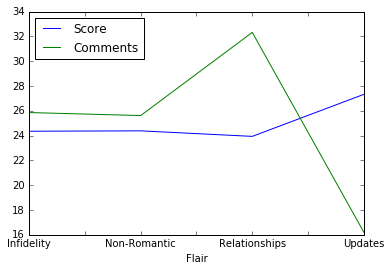

In [119]:
f_score_com_pcts.plot()

In [203]:
d = {}
for key, value in rel_df.groupby('Flair'):
        d['%s' % key] = value['Score']
        
H, p_val = stats.mstats.kruskalwallis(d['Infidelity'], d['Non-Romantic'], 
                                      d['Relationships'], d['Updates'])
print "The test statistic is %1.3f, and the significance level is %1.3f." % (H, p_val)

The test statistic is 17.772, and the significance level is 0.000.


In [202]:
d = {}
for key, value in rel_df.groupby('Flair'):
        d['%s' % key] = value['Comments']
        
H, p_val = stats.mstats.kruskalwallis(d['Infidelity'], d['Non-Romantic'], 
                                      d['Relationships'], d['Updates'])
print "The test statistic is %1.3f, and the significance level is %1.3f." % (H, p_val)

The test statistic is 177.918, and the significance level is 0.000.


In [105]:
score_com_day = rel_df.groupby('DayOfWeek')[
    ['Score', 'Comments']].median()
score_com_day = score_com_day.reindex(['Mon', 'Tues', 'Weds', 
                                       'Thurs', 'Fri', 'Sat', 
                                       'Sun'])

In [106]:
score_com_day

,Score,Comments
DayOfWeek,,
Mon,1247.0,242
Tues,1207.5,272
Weds,1249.0,296
Thurs,1107.0,284
Fri,1304.0,269
Sat,1242.0,268
Sun,1235.0,249


In [109]:
score_com_pcts = score_com_day.apply(lambda c: c/c.sum() * 100, axis=0)
score_com_pcts

,Score,Comments
DayOfWeek,,
Mon,14.514346,12.872340
Tues,14.054589,14.468085
Weds,14.537624,15.744681
Thurs,12.884828,15.106383
Fri,15.177792,14.308511
Sat,14.456149,14.255319
Sun,14.374673,13.244681


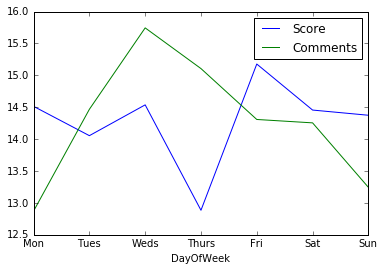

In [110]:
score_com_pcts.plot()

In [200]:
d = {}
for key, value in rel_df.groupby('DayOfWeek'):
        d['%s' % key] = value['Score']
        
H, p_val = stats.mstats.kruskalwallis(d['Mon'], d['Tues'], d['Weds'], d['Thurs'], 
                                       d['Fri'], d['Sat'], d['Sun'])
print "The test statistic is %1.3f, and the significance level is %1.3f." % (H, p_val)

The test statistic is 8.843, and the significance level is 0.183.


In [201]:
d = {}
for key, value in rel_df.groupby('DayOfWeek'):
        d['%s' % key] = value['Comments']
        
H, p_val = stats.mstats.kruskalwallis(d['Mon'], d['Tues'], d['Weds'], d['Thurs'], 
                                       d['Fri'], d['Sat'], d['Sun'])
print "The test statistic is %1.3f, and the significance level is %1.3f." % (H, p_val)

The test statistic is 11.957, and the significance level is 0.063.
